In [1]:
%load_ext autoreload
%autoreload 2
import os
import time
import pickle
import numpy as np
import pandas as pd
import multiprocessing as mp
from IPython.display import HTML, SVG

from pydrake.geometry import MeshcatVisualizer, MeshcatVisualizerParams, Role, StartMeshcat
from pydrake.geometry.optimization import IrisInConfigurationSpace, IrisOptions
from pydrake.multibody.parsing import LoadModelDirectives, Parser, ProcessModelDirectives
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
# from pydrake.planning.common_robotics_utilities import SimpleRRTPlannerState
from pydrake.solvers import GurobiSolver, MosekSolver
from pydrake.systems.framework import DiagramBuilder

from gcs.linear import LinearGCS
from gcs.rounding import randomForwardPathSearch
# from reproduction.prm_comparison.planning import PRM, BiRRT
from reproduction.prm_comparison.helpers import (
    ForwardKinematics,
    get_traj_length,
    InverseKinematics,
    is_traj_confined,
    make_traj,
    visualize_trajectory,
)
from reproduction.util import *

# GurobiSolver.AcquireLicense()
os.environ["MOSEKLM_LICENSE_FILE"] = "/Users/nolan/mosek/mosek.lic"
MosekSolver.AcquireLicense()
print("Mosek is enabled: ", MosekSolver().enabled())

Mosek is enabled:  True


In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [3]:
SEED = 17
np.random.seed(SEED)

In [4]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
parser = Parser(plant)
parser.package_map().Add("gcs", GcsDir())

directives_file = FindModelFile("models/iiwa14_spheres_collision_welded_gripper.yaml")
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
[iiwa, wsg, shelf, binR, binL, table] =  models
 

plant.Finalize()

meshcat_params = MeshcatVisualizerParams()
meshcat_params.delete_on_initialization_event = False
meshcat_params.role = Role.kIllustration
# meshcat_params.role = Role.kProximity
meshcat_cpp = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, meshcat_params)

diagram = builder.Build()

context = diagram.CreateDefaultContext()
#plant_context = plant.GetMyContextFromRoot(context)
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 =[0, 0.3, 0, -1.8, 0, 1, 1.57]
plant.SetPositions(plant_context, q0)
# diagram.Publish(context)

# Generate Iris Regions
### via manual seeds

In [5]:
milestones =  {"Above Shelve": [[0.75, 0, 0.9],    [0, -np.pi, -np.pi/2]],   
                "Top Rack":    [[0.75, 0, 0.67],   [0, -np.pi, -np.pi/2]],   
                "Middle Rack": [[0.75, 0, 0.41],   [0, -np.pi, -np.pi/2]],       
                "Left Bin":    [[0.0,  0.6, 0.22], [np.pi/2, np.pi, 0]], 
                "Right Bin":   [[0.0, -0.6, 0.22], [np.pi/2, np.pi, np.pi]]}

additional_seed_points = {"Front to Shelve":np.array([0, 0.2, 0, -2.09, 0, -0.3, np.pi/2]), 
                          "Left to Shelve": np.array([0.8, 0.7, 0, -1.6, 0, 0, np.pi/2]),
                          "Right to Shelve":np.array([-0.8, 0.7, 0, -1.6, 0, 0, np.pi/2])} 

q0 =[0, 0.3, 0, -1.8, 0, 1, 1.57]
milestone_configurations =  {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in milestones.items()}

seed_points = {**milestone_configurations, **additional_seed_points}

In [6]:
iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 10
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.01
CORE_CNT = mp.cpu_count() # you may edit this

In [7]:
def calcRegion(seed, verbose):
    start_time = time.time()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    plant.SetPositions(plant_context, seed)
    hpoly = IrisInConfigurationSpace(plant, plant_context, iris_options)
    print("Seed:", seed, "\tTime:", time.time() - start_time, flush=True)
    return hpoly

def generateRegions(seed_points, verbose = True):
    seeds = list(seed_points.values()) if type(seed_points) is dict else seed_points
    regions = []
    loop_time = time.time()
    with mp.Pool(processes = CORE_CNT) as pool:
        regions = pool.starmap(calcRegion, [[seed, verbose] for seed in seeds])
    
    if verbose:
        print("Loop time:", time.time() - loop_time)
    
    if type(seed_points) is dict:
        return dict(list(zip(seed_points.keys(), regions)))
    
    return regions

In [ ]:
regions = generateRegions(seed_points)

## via pre-generated regions

In [8]:
#load regions
with open(os.path.join(GcsDir(), "reproduction/prm_comparison/iris.pkl"), "rb") as f:
    regions = pickle.load(f)

digraph GraphOfConvexSets {
labelloc=t;
v1315 [label="v0"]
v1316 [label="v1"]
v1317 [label="v2"]
v1318 [label="v3"]
v1319 [label="v4"]
v1320 [label="v5"]
v1321 [label="v6"]
v1322 [label="v7"]
v1315 -> v1316 [label="(v0, v1)"];
v1316 -> v1315 [label="(v1, v0)"];
v1315 -> v1318 [label="(v0, v3)"];
v1318 -> v1315 [label="(v3, v0)"];
v1315 -> v1319 [label="(v0, v4)"];
v1319 -> v1315 [label="(v4, v0)"];
v1315 -> v1321 [label="(v0, v6)"];
v1321 -> v1315 [label="(v6, v0)"];
v1315 -> v1322 [label="(v0, v7)"];
v1322 -> v1315 [label="(v7, v0)"];
v1316 -> v1318 [label="(v1, v3)"];
v1318 -> v1316 [label="(v3, v1)"];
v1316 -> v1320 [label="(v1, v5)"];
v1320 -> v1316 [label="(v5, v1)"];
v1316 -> v1322 [label="(v1, v7)"];
v1322 -> v1316 [label="(v7, v1)"];
v1317 -> v1320 [label="(v2, v5)"];
v1320 -> v1317 [label="(v5, v2)"];
v1318 -> v1320 [label="(v3, v5)"];
v1320 -> v1318 [label="(v5, v3)"];
v1318 -> v1321 [label="(v3, v6)"];
v1321 -> v1318 [label="(v6, v3)"];
v1319 -> v1320 [label="(v4, v5)"];
v13

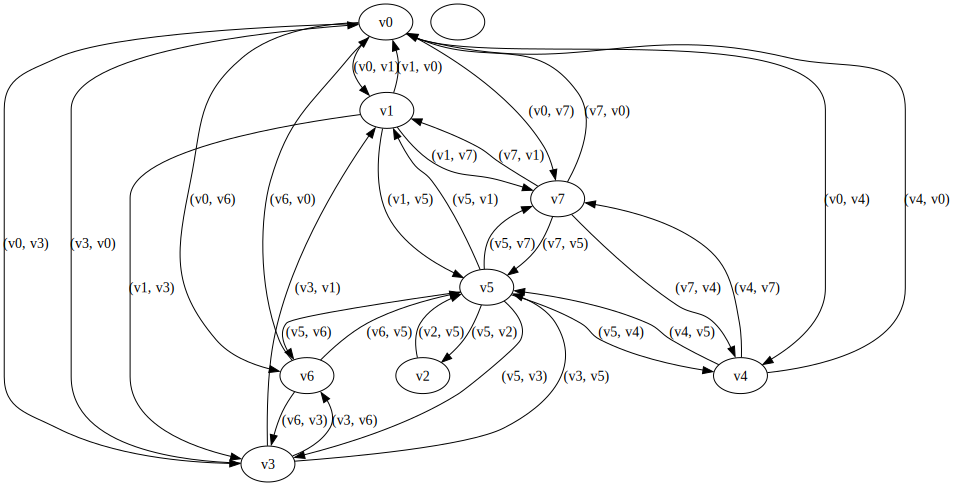

In [9]:
# gcs = LinearGCS({f"q_{i + 1}":r for i, r in enumerate(regions.values())})
# gcs = LinearGCS({f"q_{i + 1}":r for i, r in enumerate(regions)})
gcs = LinearGCS(regions)
SVG(gcs.VisualizeGraph())

In [29]:
# my test: bezierGCS -- time cost: 1; path length: 1
start = np.array([0.30309668, 0.70918771, -0.12844925, -1.6049653, 0.30388439, -0.74434504, 1.42963035])
goal = np.array([1.20570511, 0.7956385, 0.35750584, -1.47261015, -0.31592979, 0.93008018, 1.65418276])

from gcs.bezier import *
bezier_gcs = BezierGCS(regions, 5, 2)
bezier_gcs.setPaperSolverOptions()
bezier_gcs.addTimeCost(1)
bezier_gcs.addPathLengthCost(1)
bezier_gcs.addSourceTarget(start, goal)

start_time = time.time()
bezier_gcs.SolvePath()
end_time = time.time()
print(f"time taken: {end_time - start_time} sec")

source -> v2
v2 -> v5
v5 -> v6
v6 -> v3
v3 -> target
time taken: 111.0089590549469 sec


In [10]:
# my test: bezierGCS -- time cost: 1; path length: 0
start = np.array([0.30309668, 0.70918771, -0.12844925, -1.6049653, 0.30388439, -0.74434504, 1.42963035])
goal = np.array([1.20570511, 0.7956385, 0.35750584, -1.47261015, -0.31592979, 0.93008018, 1.65418276])

from gcs.bezier import *
bezier_gcs = BezierGCS(regions, 5, 2)
gcs.setSolver(MosekSolver())
bezier_gcs.setPaperSolverOptions()
bezier_gcs.addTimeCost(1)
bezier_gcs.addSourceTarget(start, goal)

start_time = time.time()
bezier_gcs.SolvePath()
end_time = time.time()
print(f"time taken: {end_time - start_time} sec")

source -> v2
v2 -> v5
v5 -> v3
v3 -> target
time taken: 18.732216835021973 sec


In [32]:
# my test: bezierGCS -- time cost: 0; path length: 1
start = np.array([0.30309668, 0.70918771, -0.12844925, -1.6049653, 0.30388439, -0.74434504, 1.42963035])
goal = np.array([1.20570511, 0.7956385, 0.35750584, -1.47261015, -0.31592979, 0.93008018, 1.65418276])

from gcs.bezier import *
bezier_gcs = BezierGCS(regions, 5, 2)
bezier_gcs.setPaperSolverOptions()
bezier_gcs.addPathLengthCost(1)
bezier_gcs.addSourceTarget(start, goal)

start_time = time.time()
bezier_gcs.SolvePath()
end_time = time.time()
print(f"time taken: {end_time - start_time} sec")

source -> v2
v2 -> v5
v5 -> v6
v6 -> v3
v3 -> target
time taken: 170.7407932281494 sec


# Build PRM

In [7]:
collision_step_size = 0.02
K = 5
roadmap_size = 15000

#initlize with seeds for fairness
prm = PRM(plant, diagram, collision_step_size, SEED, K, list(seed_points.values()))

NameError: name 'PRM' is not defined

### Load Roadmap if you don't want to wait 15 minutes

In [ ]:
#TODO use wget here to download th prm map from server
prm.load(os.path.join(GcsDir(), "data/prm_comparison/15k_presplined.rmp"))

### Or Grow it 

In [ ]:
solve_timeout = 200
goal_bias = 0.05
step_size = 0.1
birrt = BiRRT(plant, diagram, collision_step_size, SEED, step_size, goal_bias, solve_timeout)

### Connect via BiRRT first
Given the knowledge of the Graph of Convex Sets, we will use BiRRT to connect the edges. All of the nodes of the RRT trees will be added to the PRM map

In [ ]:
pairs_2_connect = [
  [SimpleRRTPlannerState(seed_points["Front to Shelve"]), SimpleRRTPlannerState(seed_points["Top Rack"])],
  [SimpleRRTPlannerState(seed_points["Front to Shelve"]), SimpleRRTPlannerState(seed_points["Middle Rack"])],
  [SimpleRRTPlannerState(seed_points["Front to Shelve"]), SimpleRRTPlannerState(seed_points["Left Bin"])],
  [SimpleRRTPlannerState(seed_points["Front to Shelve"]), SimpleRRTPlannerState(seed_points["Right Bin"])],
    
  [SimpleRRTPlannerState(seed_points["Left Bin"]), SimpleRRTPlannerState(seed_points["Above Shelve"])],
  [SimpleRRTPlannerState(seed_points["Left Bin"]), SimpleRRTPlannerState(seed_points["Left to Shelve"])],

    
  [SimpleRRTPlannerState(seed_points["Right Bin"]), SimpleRRTPlannerState(seed_points["Above Shelve"])],
  [SimpleRRTPlannerState(seed_points["Right Bin"]), SimpleRRTPlannerState(seed_points["Right to Shelve"])],
    
  [SimpleRRTPlannerState(seed_points["Above Shelve"]), SimpleRRTPlannerState(seed_points["Left to Shelve"])],
  [SimpleRRTPlannerState(seed_points["Above Shelve"]), SimpleRRTPlannerState(seed_points["Right to Shelve"])],
]

prm = PRM(plant, diagram, collision_step_size, SEED, K)

start_time = time.time()

for start_tree, goal_tree in  pairs_2_connect:
    result, start_tree_extended, end_tree_extended = birrt.connect([start_tree], [goal_tree], use_parallel = True)
    if len(result.Path()) == 0:
        raise Exception("Failed to connect nodes")
    prm.addNodes(list(map(lambda x: x.GetValueImmutable(), start_tree_extended)) + list(map(lambda x: x.GetValueImmutable(), end_tree_extended)))

print(f"Roadmap extended to {prm.roadmap_size} in {round(time.time()-start_time,2)} s")

### Continue growing the Roadmap

In [ ]:
stats = prm.GrowRoadMap(roadmap_size, True)
print(f'Grow time: {stats["growing_time"]} s') 

In [ ]:
prm.save(os.path.join(GcsDir(), "data/prm_comparison/15k_presplined.rmp"))

# Run Comparison

In [17]:
def getGCSPath(sequence, verbose = False):
    path = [sequence[0]]
    run_time = 0.0
    for start_pt, goal_pt in zip(sequence[:-1], sequence[1:]):
        gcs = LinearGCS(regions.copy())
        try:
            gcs.addSourceTarget(start_pt, goal_pt)
            print(f"start_pt: {start_pt}")
            print(f"goal_pt: {goal_pt}")
            print()
        except:
            print("failed")
            continue
        gcs.setRoundingStrategy(randomForwardPathSearch, max_paths = 10, max_trials = 100, seed = SEED)
        gcs.setSolver(MosekSolver())
        start_time = time.time()
        waypoints, results_dict = gcs.SolvePath(rounding=True, verbose=False, preprocessing=True)
        end_time = time.time()
        print(f"time taken: {end_time - start_time}")
        if waypoints is None:
            if verbose:
                print(f"Failed between {start_pt} and {goal_pt}")
            return None

#         run_time += results_dict["preprocessing_stats"]["linear_programs"]
        run_time += results_dict["relaxation_solver_time"]
        run_time += results_dict["total_rounded_solver_time"]
        if verbose:
            print("Convex Relaxation", round(results_dict["relaxation_cost"], 3),
                  "min hard result cost", round(results_dict["rounded_cost"], 3),
                  "Gap", round((results_dict["rounded_cost"] - results_dict["relaxation_cost"])/results_dict["relaxation_cost"], 3))
    
        path += waypoints.T[1:].tolist()
    return np.stack(path).T, run_time

def shortcut(path):
    """Those values are used by TRI"""
    return prm.shortcut(np.stack(path),
                 max_iter = 200,
                 max_failed_iter = 200,
                 max_backtracking_steps = 0,
                 max_shortcut_fraction = 1.0,
                 resample_shortcuts_interval = 0.25,
                 check_for_marginal_shortcuts = False)

# Demonstration

In [14]:
demonstration =  {"Above Shelve": [[0.75, -0.12, 0.9], [0, -np.pi, -np.pi/2]],   
                "Top Rack":       [[0.75, 0.12, 0.67], [0, -np.pi, -np.pi/2]],   
                "Middle Rack":    [[0.75, 0.12, 0.41], [0, -np.pi, -np.pi/2]],       
                "Left Bin":       [[0.08, 0.6, 0.22],  [np.pi/2, np.pi, 0]], 
                "Right Bin":      [[-0.08, -0.6, 0.22], [np.pi/2, np.pi, np.pi]]}

q0 =[0, 0.3, 0, -1.8, 0, 1, 1.57]
demonstration_configurations =  {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in demonstration.items()}


In [15]:
demo_a = [demonstration_configurations["Above Shelve"],
          demonstration_configurations["Top Rack"]]

demo_b = [demonstration_configurations["Top Rack"],
          demonstration_configurations["Middle Rack"]]

demo_c = [demonstration_configurations["Middle Rack"],
          demonstration_configurations["Left Bin"]]

demo_d = [demonstration_configurations["Left Bin"],
          demonstration_configurations["Right Bin"]]

demo_e = [demonstration_configurations["Right Bin"],
          demonstration_configurations["Above Shelve"]]

demo_f = [demonstration_configurations["Above Shelve"],
         seed_points["Left to Shelve"]]


demo_circle = [demonstration_configurations["Above Shelve"],
               demonstration_configurations["Top Rack"],
               demonstration_configurations["Middle Rack"],
               demonstration_configurations["Left Bin"],
               demonstration_configurations["Right Bin"],
               demonstration_configurations["Above Shelve"]]



In [18]:
execute_demo = demo_circle
GCS_path, GCS_time = getGCSPath(execute_demo, verbose = True)
linear_gcs_traj = make_traj(GCS_path, speed = 2)
print(f"Linear GCS length: {round(get_traj_length(linear_gcs_traj), 3)}, and time: {round(GCS_time, 3)} s")

# PRM_path, PRM_time = prm.getPath(execute_demo, verbose = True)
# prm_traj = make_traj(PRM_path, speed = 2)
# print(f"PRM length: {round(get_traj_length(prm_traj), 3)}, and time: {round(PRM_time, 3)} s")
#
# sPRM_path, sPRM_time = prm.getPath(execute_demo, path_processing = shortcut)
# sprm_traj = make_traj(sPRM_path, speed = 2)
# print(f"Smoothed PRM length: {round(get_traj_length(sprm_traj), 3)}, and time: {round(sPRM_time, 3)} s")


failed
failed
start_pt: [ 0.30309668  0.70918771 -0.12844925 -1.6049653   0.30388439 -0.74434504
  1.42963035]
goal_pt: [ 1.20570511  0.7956385   0.35750584 -1.47261015 -0.31592979  0.93008018
  1.65418276]

time taken: 0.24408507347106934
Convex Relaxation 2.481 min hard result cost 2.497 Gap 0.007
start_pt: [ 1.20570511  0.7956385   0.35750584 -1.47261015 -0.31592979  0.93008018
  1.65418276]
goal_pt: [-1.46880722  0.79622676 -0.36068249 -1.47251535  0.318728    0.9307579
  1.22061518]

time taken: 0.33483123779296875
Convex Relaxation 3.258 min hard result cost 3.613 Gap 0.109
start_pt: [-1.46880722  0.79622676 -0.36068249 -1.47251535  0.318728    0.9307579
  1.22061518]
goal_pt: [-0.30102434  0.52369055  0.22433511 -0.59851624  0.22659828  0.48185299
  1.25736947]

time taken: 0.24493002891540527
Convex Relaxation 1.806 min hard result cost 1.86 Gap 0.03
Linear GCS length: 9.035, and time: 0.625 s


In [ ]:
is_traj_confined(sprm_traj, regions)

In [32]:
visualize_trajectory(meshcat,
                     # [linear_gcs_traj,prm_traj,sprm_traj],
                     [linear_gcs_traj],
                     show_line = True,
                     iiwa_ghosts = execute_demo,
                     alpha =  0.3,
                     regions = [])


In [33]:
with open ("GCS_PRM15k_comparison.html", "w") as f:
    f.write(meshcat.StaticHtml())

## Comparison Table for Paper


In [ ]:
demos_for_paper = [demo_a, demo_b, demo_c, demo_d, demo_e]

proposed_planner_data = []
PRM_data = []
sPRM_data = []

N = 10 # We ran this 100 in the paper 
for _ in range(N):
    #extract trajectory and time 
    trajectories = map(lambda d:[getGCSPath(d),prm.getPath(d),prm.getPath(d, path_processing = shortcut)], demos_for_paper)
    #get length of trajectory
    length_time_list = map(lambda traj_time: [[get_traj_length(make_traj(trj)), t] for trj, t in traj_time], trajectories)
    #flatten for pandas
    length_time_list = np.array(list(length_time_list))
    
    proposed_planner_data.append(length_time_list[:,0].flatten())
    PRM_data.append(length_time_list[:,1].flatten())
    sPRM_data.append(length_time_list[:,2].flatten())
    
proposed_planner_data = np.mean(proposed_planner_data, axis = 0)
PRM_data = np.mean(PRM_data, axis = 0)
sPRM_data = np.mean(sPRM_data, axis = 0)

In [ ]:
cols = {"Proposed Planner":proposed_planner_data,
        "Regular PRM":PRM_data,
        "Shortcut PRM":sPRM_data}

index = pd.MultiIndex.from_tuples([('q1-q2', 'length (rad)'), ('q1-q2', 'runtime (s)'),
                                    ('q2-q3', 'length (rad)'), ('q2-q3', 'runtime (s)'),
                                    ('q3-q4', 'length (rad)'), ('q3-q4', 'runtime (s)'),
                                    ('q4-q5', 'length (rad)'), ('q4-q5', 'runtime (s)'),
                                    ('q5-q1', 'length (rad)'), ('q5-q1', 'runtime (s)'),], names=["Task", ""])
df = pd.DataFrame(data = cols, index=index)

In [ ]:
df.round(2)

## Debug
When playing with the demonstration points, use this to understand where PRM fails and where the regions to include the configurations

In [ ]:
for k,v in {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in demonstration.items()}.items():
    print(k, regions[k].PointInSet(v), not prm.getPath([q0, v]) is None)